<a href="https://colab.research.google.com/github/PIYAL-DATTA/Multi-attack/blob/main/NSl_KDD_EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
path = kagglehub.dataset_download("hassan06/nslkdd")

print("Path to dataset files:", path)

train_path = os.path.join(path, "KDDTrain+.txt")
test_path  = os.path.join(path, "KDDTest+.txt")

print("Path to Train dataset files:", train_path)
print("Path to Test dataset files:", test_path)

column_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
    'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate','label','difficulty_level'
]

train_df = pd.read_csv(train_path, names=column_names)
test_df = pd.read_csv(test_path, names=column_names)
df = pd.concat([train_df, test_df], ignore_index=True)
categorical_cols = ['protocol_type', 'service', 'flag']
encoders = {}
for col in categorical_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc

def map_attack(label):
    dos = ['back','land','neptune','pod','smurf','teardrop','mailbomb','apache2','processtable','udpstorm']
    probe = ['satan','ipsweep','nmap','portsweep','mscan','saint']
    r2l = ['guess_passwd','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named']
    u2r = ['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps']

    if label == 'normal': return 0 # 'normal'
    elif label in dos: return 1 # 'DoS'
    elif label in probe: return 2 # 'Probe'
    elif label in r2l: return 2 # 'R2L'
    elif label in u2r: return 2 # 'U2R'
    else: return 2 # 'unknown'

df['attack_class'] = df['label'].apply(map_attack)
y_encoded = df['attack_class']
num_classes = len(y_encoded.unique())
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))
scaler = MinMaxScaler()
X = df.drop(columns=['label','attack_class'])
X_scaled = scaler.fit_transform(X)
# X_reshaped = X_scaled.reshape(-1, 6, 7, 1)
# X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

Path to dataset files: /kaggle/input/nslkdd
Path to Train dataset files: /kaggle/input/nslkdd/KDDTrain+.txt
Path to Test dataset files: /kaggle/input/nslkdd/KDDTest+.txt


# EfficientNetV2

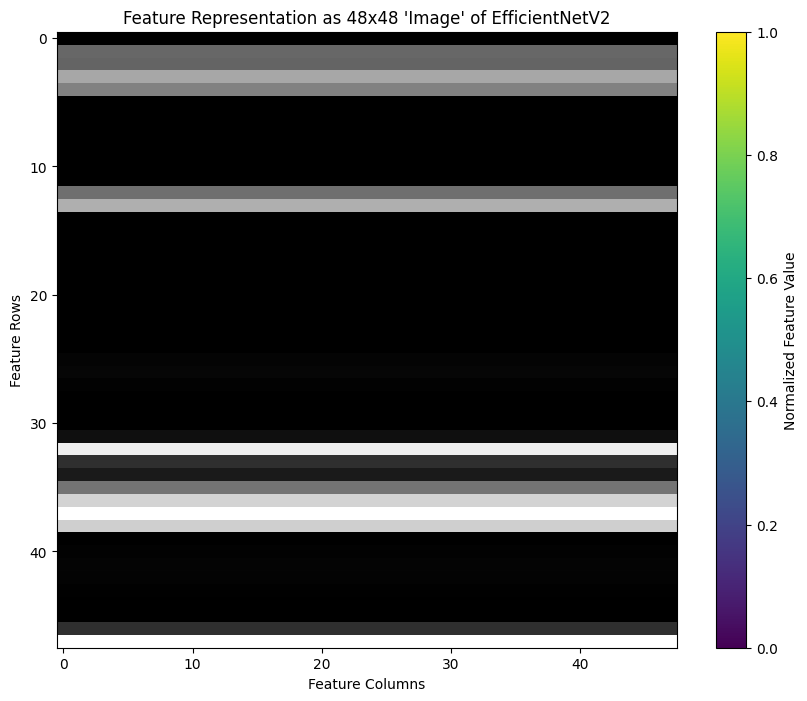


Corresponding Feature Names (Original 42 features):
0: duration
1: protocol_type
2: service
3: flag
4: src_bytes
5: dst_bytes
6: land
7: wrong_fragment
8: urgent
9: hot
10: num_failed_logins
11: logged_in
12: num_compromised
13: root_shell
14: su_attempted
15: num_root
16: num_file_creations
17: num_shells
18: num_access_files
19: num_outbound_cmds
20: is_host_login
21: is_guest_login
22: count
23: srv_count
24: serror_rate
25: srv_serror_rate
26: rerror_rate
27: srv_rerror_rate
28: same_srv_rate
29: diff_srv_rate
30: srv_diff_host_rate
31: dst_host_count
32: dst_host_srv_count
33: dst_host_same_srv_rate
34: dst_host_diff_srv_rate
35: dst_host_same_src_port_rate
36: dst_host_srv_diff_host_rate
37: dst_host_serror_rate
38: dst_host_srv_serror_rate
39: dst_host_rerror_rate
40: dst_host_srv_rerror_rate
41: difficulty_level


In [ ]:
# Install required libraries
# !pip install -U tensorflow
# !pip install -U keras

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import class_weight
import os

# Load and preprocess data (from your existing code)
# ... [your data loading and preprocessing code here] ...

# Reshape data to 42x1 (treat as 1-channel "image")
X_reshaped = X_scaled.reshape(-1, 42, 1, 1)  # New shape: (samples, 42, 1, 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Preprocessing function (applied only once)
def preprocess_for_effnet(x):
    x = tf.image.resize(x, [48, 48])  # Resize to 48x48
    x = tf.repeat(x, 3, axis=-1)      # Replicate channels (1->3)
    return x

# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply preprocessing ONLY in dataset pipeline
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_for_effnet(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_for_effnet(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# to see data Image ===========================================================>
# Get the first sample using an iterator
for sample, label in train_dataset.take(1):
  sample = sample.numpy().squeeze() # Convert to numpy and remove channel dimension

# Create plot
plt.figure(figsize=(10, 8))
plt.imshow(sample, cmap='viridis', aspect='auto')
plt.title("Feature Representation as 48x48 'Image' of EfficientNetV2")
plt.xlabel("Feature Columns")
plt.ylabel("Feature Rows")
plt.colorbar(label='Normalized Feature Value')
plt.show()

# Print corresponding feature names - Note: Feature names don't directly map to pixels after resizing
print("\nCorresponding Feature Names (Original 42 features):")
for i, name in enumerate(X.columns):
    print(f"{i}: {name}")
# Endd ===================================================================================>

In [ ]:
# Batch and prefetch
batch_size = 64
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build model with corrected input shape
def create_model():
    base_model = EfficientNetV2B0(
        include_top=False,
        weights=None,
        input_shape=(48, 48, 3),  # Directly use preprocessed shape
        pooling='avg'
    )

    model = models.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Train the model
epochs = 20
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    class_weight=class_weights
)

# Evaluate
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,667 (23.21 MB)

 Trainable params: 6,023,059 (22.98 MB)

 Non-trainable params: 60,608 (236.75 KB)

Epoch 1/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8778 - loss: 0.3289

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test to numpy array if needed
y_test_np = np.concatenate([y for x, y in test_dataset], axis=0)

# Compute metrics
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_classes, digits = 4))

# Calculate macro and weighted averages
precision_macro = precision_score(y_test_np, y_pred_classes, average='macro')
recall_macro = recall_score(y_test_np, y_pred_classes, average='macro')
f1_macro = f1_score(y_test_np, y_pred_classes, average='macro')

precision_weighted = precision_score(y_test_np, y_pred_classes, average='weighted')
recall_weighted = recall_score(y_test_np, y_pred_classes, average='weighted')
f1_weighted = f1_score(y_test_np, y_pred_classes, average='weighted')

print(f"\nMacro Averages:")
print(f"Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-score: {f1_macro:.4f}")

print(f"\nWeighted Averages:")
print(f"Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1-score: {f1_weighted:.4f}")

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test_np, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'DDoS', 'BotNet'],
            yticklabels=['Normal', 'DDoS', 'BotNet'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()